# Experiments

In [1]:
import pandas as pd
from blocksnet.enums import LandUse

FEATURES_COLS = ['footprint_area', 'build_floor_area']
ADDITIONAL_COLS = [lu.value for lu in LandUse]

In [2]:
from tqdm import tqdm
from imputers import SmImputer
from blocksnet.enums import LandUse

blocks_gdf = pd.read_pickle('./data/saint_petersburg.pickle')
blocks_gdf['site_area'] = blocks_gdf.area

block_id = 2

results = {}
for land_use in tqdm(LandUse):
    gdf = blocks_gdf.copy()
    gdf.loc[block_id, [lu.value for lu in LandUse]] = 0.0
    gdf.loc[block_id,'land_use'] = land_use
    gdf.loc[block_id, land_use.value] = 1.0
    imputer = SmImputer(gdf.head(100), FEATURES_COLS, additional_cols=ADDITIONAL_COLS)
    result = imputer.impute([block_id]).loc[block_id]
    results[land_use] = result

pd.DataFrame.from_dict(results, orient='index')

100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


,footprint_area,build_floor_area
LandUse.RESIDENTIAL,10670.155126,40153.429589
LandUse.BUSINESS,10782.095721,28190.812604
LandUse.RECREATION,3567.687107,8213.145211
LandUse.INDUSTRIAL,15208.401469,32694.605206
LandUse.TRANSPORT,8346.884758,19641.046542
LandUse.SPECIAL,6553.468040,15807.714474
LandUse.AGRICULTURE,5841.453497,13794.775595


In [3]:
import os
from tqdm import tqdm
from metrics import evaluate_metrics
from imputers import MeanImputer, SknnImputer, IdwImputer, SmvNmfImputer, SmImputer

N_STEPS = 7
N_RUNS = 100

results = []

for file_name in ['saint_petersburg.pickle']: # os.listdir('./data'):
    city_name = file_name.split('.')[0]

    blocks_gdf = pd.read_pickle(f'./data/{file_name}')
    blocks_gdf['site_area'] = blocks_gdf.area

    imputers = {
        'mean': MeanImputer(blocks_gdf, FEATURES_COLS),
        'sknn': SknnImputer(blocks_gdf, FEATURES_COLS),
        'idw': IdwImputer(blocks_gdf, FEATURES_COLS),
        'smv-nmf': SmvNmfImputer(blocks_gdf, FEATURES_COLS, additional_cols=ADDITIONAL_COLS),
        'sm': SmImputer(blocks_gdf, FEATURES_COLS, additional_cols=ADDITIONAL_COLS)
    }

    for i in range(N_STEPS):

        missing_rate = round(0.1 * (i+1),1)
        n = int(len(blocks_gdf)*missing_rate)

        for _ in tqdm(range(N_RUNS), desc=f'{missing_rate}'):

            blocks_ids = blocks_gdf.sample(n).index.to_list()
            true_df = blocks_gdf.loc[blocks_ids, FEATURES_COLS].copy()

            for name,imputer in imputers.items():
                pred_df = imputer.impute(blocks_ids)
                results_dicts = evaluate_metrics(true_df, pred_df)
                for result_dict in results_dicts:
                    result_dict.update({
                        'method': name,
                        'missing_rate': missing_rate,
                        'city': city_name
                    })
                results.extend(results_dicts)


0.7:  16%|█▌        | 16/100 [05:02<26:31, 18.94s/it]/home/vasilstar/sm-imputation/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
0.7: 100%|██████████| 100/100 [32:50<00:00, 19.71s/it]


In [6]:
results_df = pd.DataFrame(results)
results_df.head()

,feature,mae,rmse,r2,r2_robust,method,missing_rate,city
0,footprint_area,13122.947986,32831.798392,-0.000305,0.091894,mean,0.1,saint_petersburg
1,build_floor_area,58217.139166,111094.886717,-0.000855,0.138761,mean,0.1,saint_petersburg
2,footprint_area,10356.628466,32069.347814,0.045616,0.900016,sknn,0.1,saint_petersburg
3,build_floor_area,42304.335486,102703.704797,0.144628,0.967242,sknn,0.1,saint_petersburg
4,footprint_area,9935.654587,32148.540260,0.040897,0.928269,idw,0.1,saint_petersburg


In [7]:
results_df.to_pickle('results.pickle')

In [15]:
results_df.groupby('method').agg({
    'mae': 'mean',
    'rmse': 'mean',
    'r2': 'mean',
    'r2_robust': 'mean'
})

,mae,rmse,r2,r2_robust
method,,,,
idw,25259.082188,60266.038856,0.113772,0.926359
mean,34706.086767,64851.154304,-0.000583,-0.005120
sknn,26348.603639,60327.641289,0.112695,0.898804
sm,18351.554237,43202.666182,0.552464,0.939108
smv-nmf,26405.678178,60263.187888,0.117193,0.889438


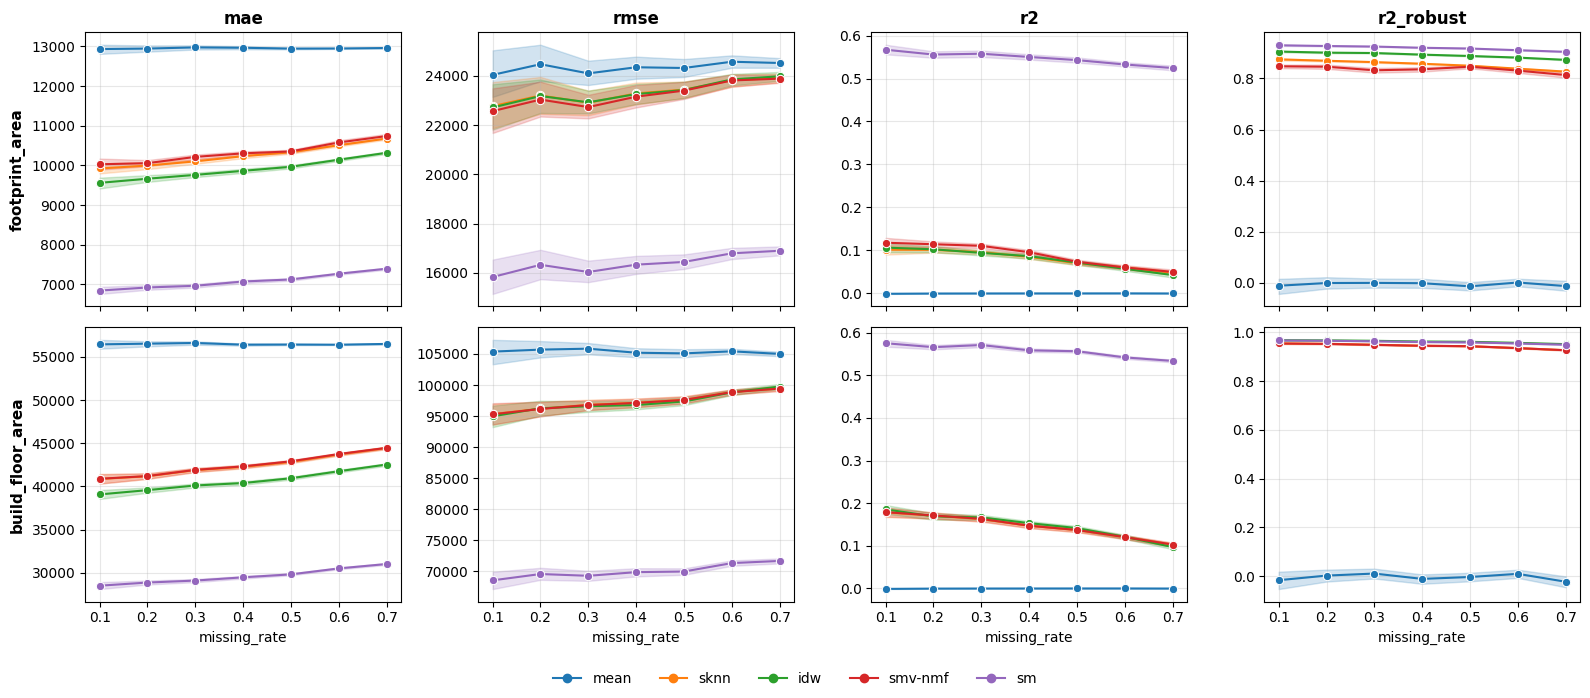

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['mae', 'rmse', 'r2', 'r2_robust']
features = results_df['feature'].unique()
methods = results_df.method.unique()
palette = sns.color_palette("tab10", n_colors=len(methods))

n_rows = len(features)
n_cols = len(metrics)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex='col', sharey=False
)

for i, feature in enumerate(features):
    sub = results_df[results_df['feature'] == feature]
    for j, metric in enumerate(metrics):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        sns.lineplot(
            data=sub,
            x='missing_rate',
            y=metric,
            hue='method',
            marker='o',
            ax=ax,
            palette=palette,
            legend=False 
        )
        if i == 0:
            ax.set_title(metric, fontsize=12, weight='bold')
        if j == 0:
            ax.set_ylabel(feature, fontsize=11, weight='bold')
        else:
            ax.set_ylabel('')
        if i != n_rows - 1:
            ax.set_xlabel('')
        ax.grid(True, alpha=0.3)

handles = [plt.Line2D([0], [0], color=palette[i], marker='o', label=meth) 
           for i, meth in enumerate(methods)]
labels = methods
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
